In [32]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'



### Other run settings
runningLocation = 'local'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/newRepeat/'
    hisTruthFilePath='../data/raw/truth/final/' # Truth file settings
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
    truthFilePath='/g/data/fu5/deg581/EAC_2yr_ObsVerification_HighRes/output/' # Truth file settings

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [33]:
def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,etaRange,xiRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

### function to load overlapping OSSE data
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName


def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

In [34]:
### Open truth file
OverlappedTruthFiles = 'yes'
if OverlappedTruthFiles == 'yes':
    truth = loadOverlappedNetcdf(hisTruthFilePath,prefixTruth,filestring='080[0-7]*.nc',overlapDays=7)
elif OverlappedTruthFiles == 'no':
    import glob
    chunks = {'ocean_time':1}

    filelist = glob.glob(hisTruthFilePath+prefixTruth+'0800*.nc')
    #datelist = np.array(range(timeRange[0],timeRange[1],4))

    for files in filelist: 
        print(files)
        # filelist.append(files)
    truth = xr.open_mfdataset(filelist,chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 
    # truth = dropDuplicateTimes(truth)


loaded from ../data/raw/truth/final/outer_his_08001.nc to ../data/raw/truth/final/outer_his_08077.nc


In [35]:
osseAna = loadOSSE(hisOSSEFilePath,prefixAnalysis,filestring='08*.nc',overlapDays=7)
osseFore = loadOSSE(hisOSSEFilePath,prefixForecast,filestring='08*.nc',overlapDays=7)


loaded from ../data/raw/newRepeat/roms_fwd_outer1_08005.nc to ../data/raw/newRepeat/roms_fwd_outer1_08077.nc
loaded from ../data/raw/newRepeat/roms_fwd_outer0_08005.nc to ../data/raw/newRepeat/roms_fwd_outer0_08077.nc


In [36]:
#xiRangeMetric = [85, 150] # upstream
#etaRangeMetric = [115, 200] #upstream
etaRangeMetric = [0, 315] # whole domain
xiRangeMetric = [0, 270] # whole domain

err,ssh_rmse_Ana_Truth = calc_rmseSpatial(osseAna.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Fore_Truth = calc_rmseSpatial(osseFore.zeta,truth.zeta,etaRangeMetric,xiRangeMetric)
err,ssh_rmse_Ana_Fore = calc_rmseSpatial(osseAna.zeta,osseFore.zeta,etaRangeMetric,xiRangeMetric)



/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


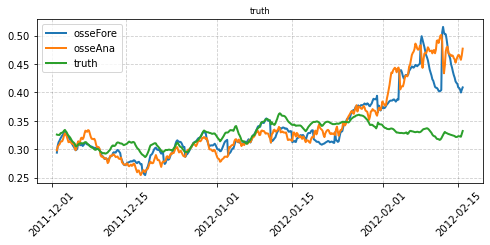

In [37]:
names = ('osseFore','osseAna','truth')
subname ='.zeta'
xlabels = ('m','m','m')
ssh_mean_timeseries = xr.Dataset()

for name in names:
    ssh_mean_timeseries[name] = eval('indexMeanMetric('+name+subname+', etaRange=etaRangeMetric, xiRange=xiRangeMetric)')

plt_params = {'linewidth':2}

fig, ax = plt.subplots(1, figsize=(8,3), sharex=True)
for run in names:
    plt_params['label'] = run
    simple_TimeSeries(ssh_mean_timeseries['ocean_time'],ssh_mean_timeseries[run],ax=ax, plt_kwargs=plt_params)
ax.set_title(run, fontsize='small',loc='center')
ax.legend()
ax.tick_params('x',labelrotation=45)

/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarni

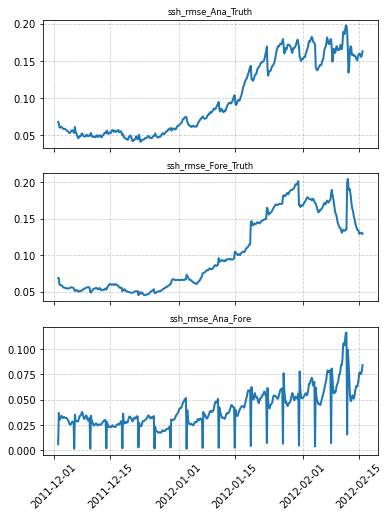

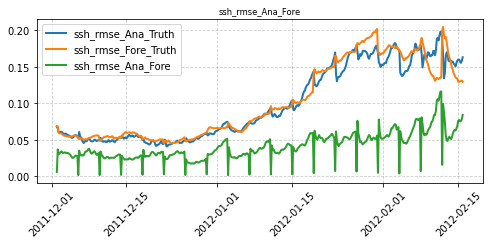

In [38]:
names = ('ssh_rmse_Ana_Truth','ssh_rmse_Fore_Truth','ssh_rmse_Ana_Fore')
xlabels = ('m','m','m')
rmse_metrics = xr.Dataset()

for name in names:
    rmse_metrics[name] = eval(name)

plt_params = {'linewidth':2}


fig, axes = plt.subplots(3, figsize=(6, 8), sharex=True)
for ax, run in zip(axes, names):
    simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
    ax.set_title(run, fontsize='small',loc='center')
    ax.tick_params('x',labelrotation=45)



fig, ax = plt.subplots(1, figsize=(8,3), sharex=True)
for run in names:
    plt_params['label'] = run
    simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics[run],ax=ax, plt_kwargs=plt_params)
ax.set_title(run, fontsize='small',loc='center')
ax.legend()
ax.tick_params('x',labelrotation=45)

/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/dave/miniconda3/envs/devel/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


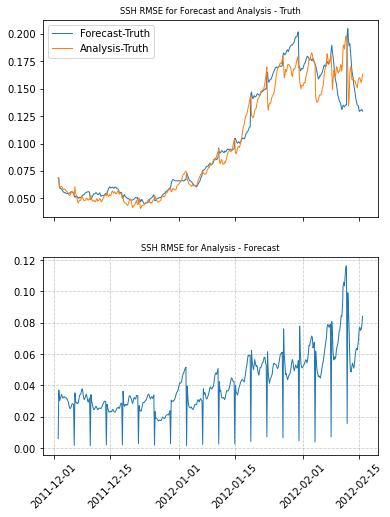

In [39]:

plt_params = {'linewidth':1}

fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax=axes[0]
plt_params = {'linewidth':1,'label':'Forecast-Truth'}
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Fore_Truth'],ax=ax, plt_kwargs=plt_params)
plt_params = {'linewidth':1,'label':'Analysis-Truth'}
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Ana_Truth'],ax=ax, plt_kwargs=plt_params)
ax.set_title('SSH RMSE for Forecast and Analysis - Truth', fontsize='small',loc='center')
ax.legend()
ax=axes[1]
simple_TimeSeries(rmse_metrics['ocean_time'],rmse_metrics['ssh_rmse_Ana_Fore'],ax=ax, plt_kwargs=plt_params)
ax.set_title('SSH RMSE for Analysis - Forecast', fontsize='small',loc='center')
ax.tick_params('x',labelrotation=45)


In [40]:
def plot_spatialMap(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)   


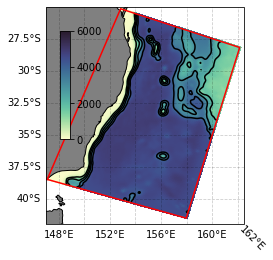

In [41]:
# xiRange = [114, 184]
# etaRange = [84, 149]



boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)


fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMap(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()